In [83]:
from distribution_inference.config.core import TrainConfig
from simple_parsing import ArgumentParser
from pathlib import Path
from tqdm import tqdm
import numpy as np
from dataclasses import replace
import os

from distribution_inference.datasets.utils import get_dataset_wrapper, get_dataset_information
from distribution_inference.config import DatasetConfig, FairnessEvalConfig
from distribution_inference.utils import flash_utils
from distribution_inference.attacks.blackbox.utils import get_preds

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [129]:
def to_preds(x):
    exp = np.exp(x)
    return exp / (1 + exp)

In [123]:
fairness_config: FairnessEvalConfig = FairnessEvalConfig.load(
    "configs/new_census/fairness_eval.json",
    drop_extra_fields=False)
# Extract configuration information from config file
train_config: TrainConfig = fairness_config.train_config
model_data_config: DatasetConfig = train_config.data_config

In [124]:
# Without-Shuffle model_config
train_config_wo_shuffle = replace(train_config, misc_config=None)

In [125]:
# Without shuffle model_config, OG raio
train_config_og = replace(train_config_wo_shuffle)
train_config_og.data_config = replace(train_config_og.data_config, value=0.5)

In [126]:
# Get dataset wrapper
ds_wrapper_class = get_dataset_wrapper(model_data_config.name)
# Get dataset info object
ds_info = get_dataset_information(model_data_config.name)()

In [127]:
data_config: DatasetConfig = replace(model_data_config)
data_config.value = 0.5
ds_baseline = ds_wrapper_class(
    data_config, skip_data=False)

In [128]:
# Check if models are graph-related
are_graph_models = ds_baseline.is_graph_data
if are_graph_models:
    # No concept of 'processed'
    data_ds, (_, test_idx) = ds_baseline.get_loaders(batch_size=fairness_config.batch_size, eval_shuffle=False)
    eval_loader = (data_ds, test_idx)
else:
    _, eval_loader = ds_baseline.get_loaders(batch_size=fairness_config.batch_size, eval_shuffle=False)

In [130]:
def get_preds_for_model_config(mc: TrainConfig):
    # Create new DS object for models and data loading
    ds_model = ds_wrapper_class(
        mc.data_config,
        skip_data=True,
        label_noise=train_config.label_noise)

    # Load models
    models = ds_model.get_models(
        mc,
        n_models=fairness_config.num_models,
        on_cpu=fairness_config.on_cpu,
        shuffle=False,
        epochwise_version=mc.save_every_epoch,
        model_arch=mc.model_arch)

    # Get predictions for models
    preds, ground_truth = get_preds(
        eval_loader, models,
        preload=fairness_config.preload,
        multi_class=mc.multi_class)
    
    # Convert to probability values if logits
    if not models[0].is_sklearn_model:
        preds = to_preds(preds)
        
    return preds, ground_truth

In [131]:
preds_shuffle, gt_shuffle = get_preds_for_model_config(train_config)

Aww /p/adversarialml/as9rw/models_new_census/60_40/mlp2/shuffle_defense/under/0.50/sex/victim/0.2


Loading models:   6%|███████████                                                                                                                                                                             | 6/100 [00:00<00:01, 49.50it/s]

Available models: 100


Generating Predictions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.65it/s]


In [132]:
preds_noshuffle, gt_no_shuffle = get_preds_for_model_config(train_config_wo_shuffle)

Loading models:  27%|█████████████████████████████████████████████████▏                                                                                                                                    | 27/100 [00:00<00:00, 261.74it/s]

Aww /p/adversarialml/as9rw/models_new_census/60_40/mlp2/normal/sex/victim/0.2
Available models: 100


Generating Predictions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.72it/s]


In [133]:
preds_og, gt_og = get_preds_for_model_config(train_config_og)

Loading models:  30%|██████████████████████████████████████████████████████▌                                                                                                                               | 30/100 [00:00<00:00, 298.47it/s]

Aww /p/adversarialml/as9rw/models_new_census/60_40/mlp2/normal/sex/victim/0.5
Available models: 100


Generating Predictions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.78it/s]


In [134]:
# Pick just the first 2 datapoints for now
picked = (7327, 1531)

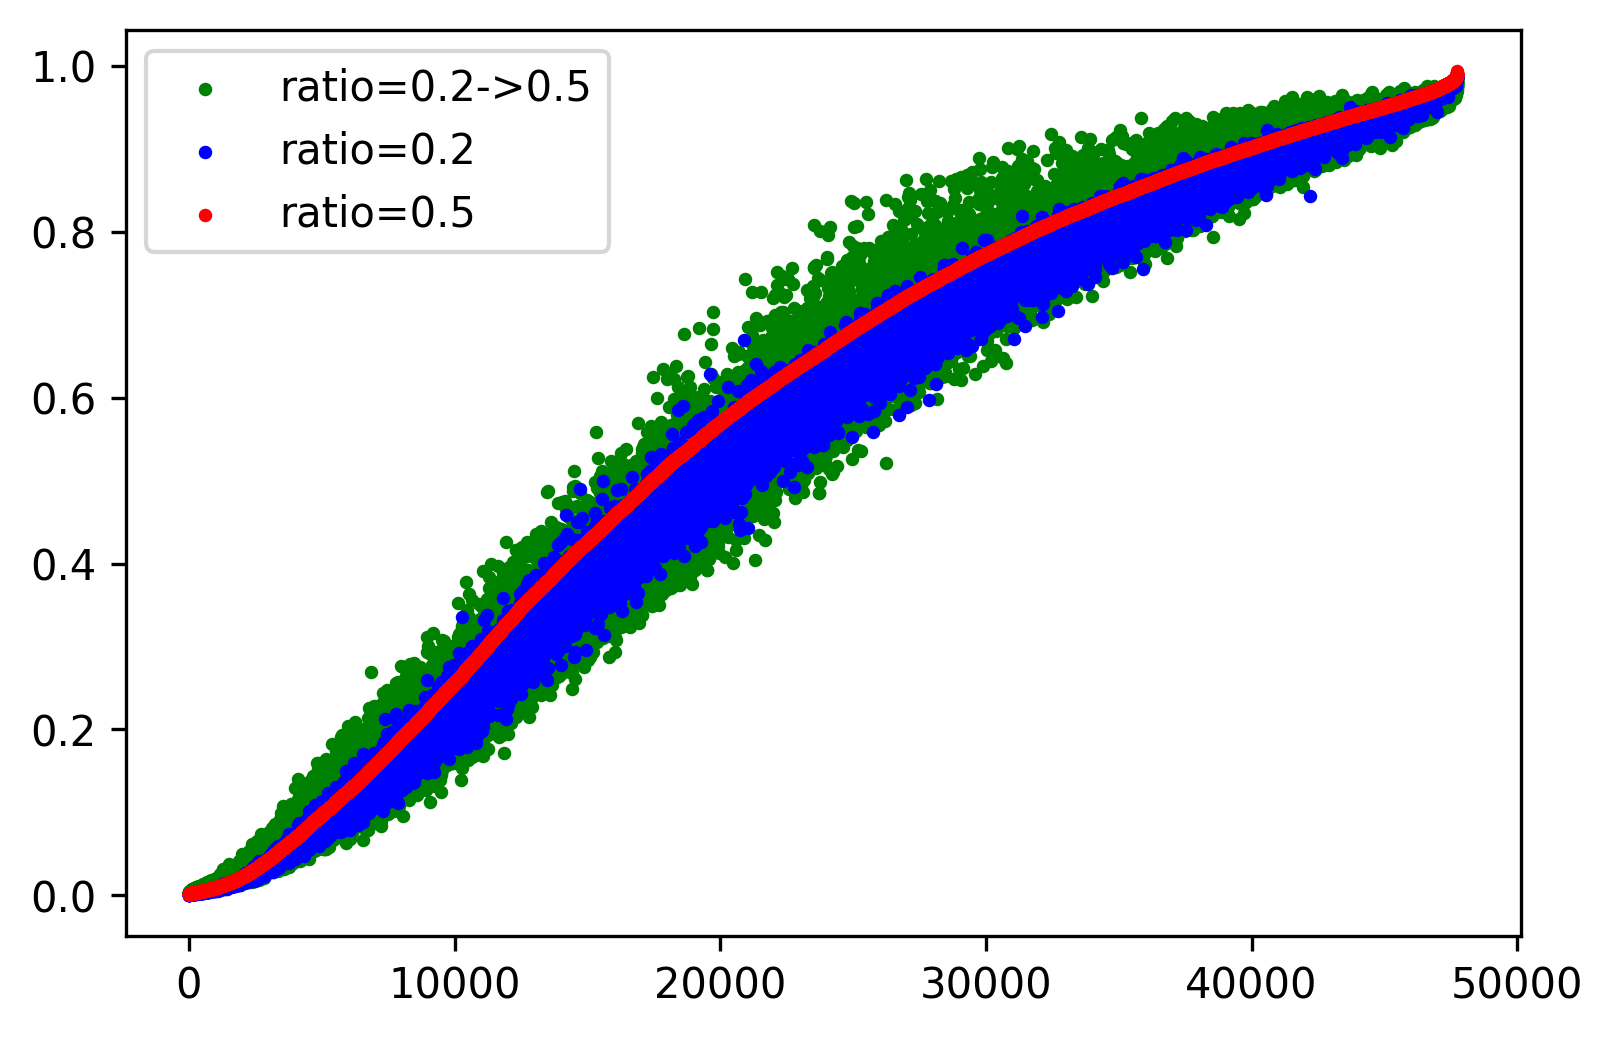

In [145]:
sorted_order = np.argsort(np.mean(preds_og, 0))[:]
plt.scatter(np.arange(len(sorted_order)), np.mean(preds_shuffle, 0)[sorted_order], c='g', s=5, label='ratio=0.2->0.5')
plt.scatter(np.arange(len(sorted_order)), np.mean(preds_noshuffle, 0)[sorted_order], c='b', s=5, label='ratio=0.2')
plt.scatter(np.arange(len(sorted_order)), np.mean(preds_og, 0)[sorted_order], c='r', s=5, label='ratio=0.5')
plt.legend()

In [146]:
def KL(x, y):
    small_eps = 1e-4
    x_ = np.clip(x, small_eps, 1 - small_eps)
    y_ = np.clip(y, small_eps, 1 - small_eps)
    x__, y__ = 1 - x_, 1 - y_
    first_term = x_ * (np.log(x_) - np.log(y_))
    second_term = x__ * (np.log(x__) - np.log(y__))
    return np.mean(first_term + second_term, 1)

In [152]:
# Compute KL divergence values between 0.1 and 0.1->0.5
xx, yy = np.triu_indices(preds_og.shape[0], k=1)
KL_vals = np.array([KL(preds_noshuffle, x,) for x in preds_shuffle])
np.mean(KL_vals)

0.017793661

In [151]:
# Between 0.5 and 0.1->0.5
KL_vals = np.array([KL(preds_og, x,) for x in preds_shuffle])
np.mean(KL_vals)

0.019130072

In [153]:
# Between 0.1 and 0.5
KL_vals = np.array([KL(preds_og, x,) for x in preds_noshuffle])
np.mean(KL_vals)

0.017681122

**Looks like models with re-sampling defense are closer to the original ratio, than the ratio they were re-sampled to. Need to get to the bottom of why this is happening**

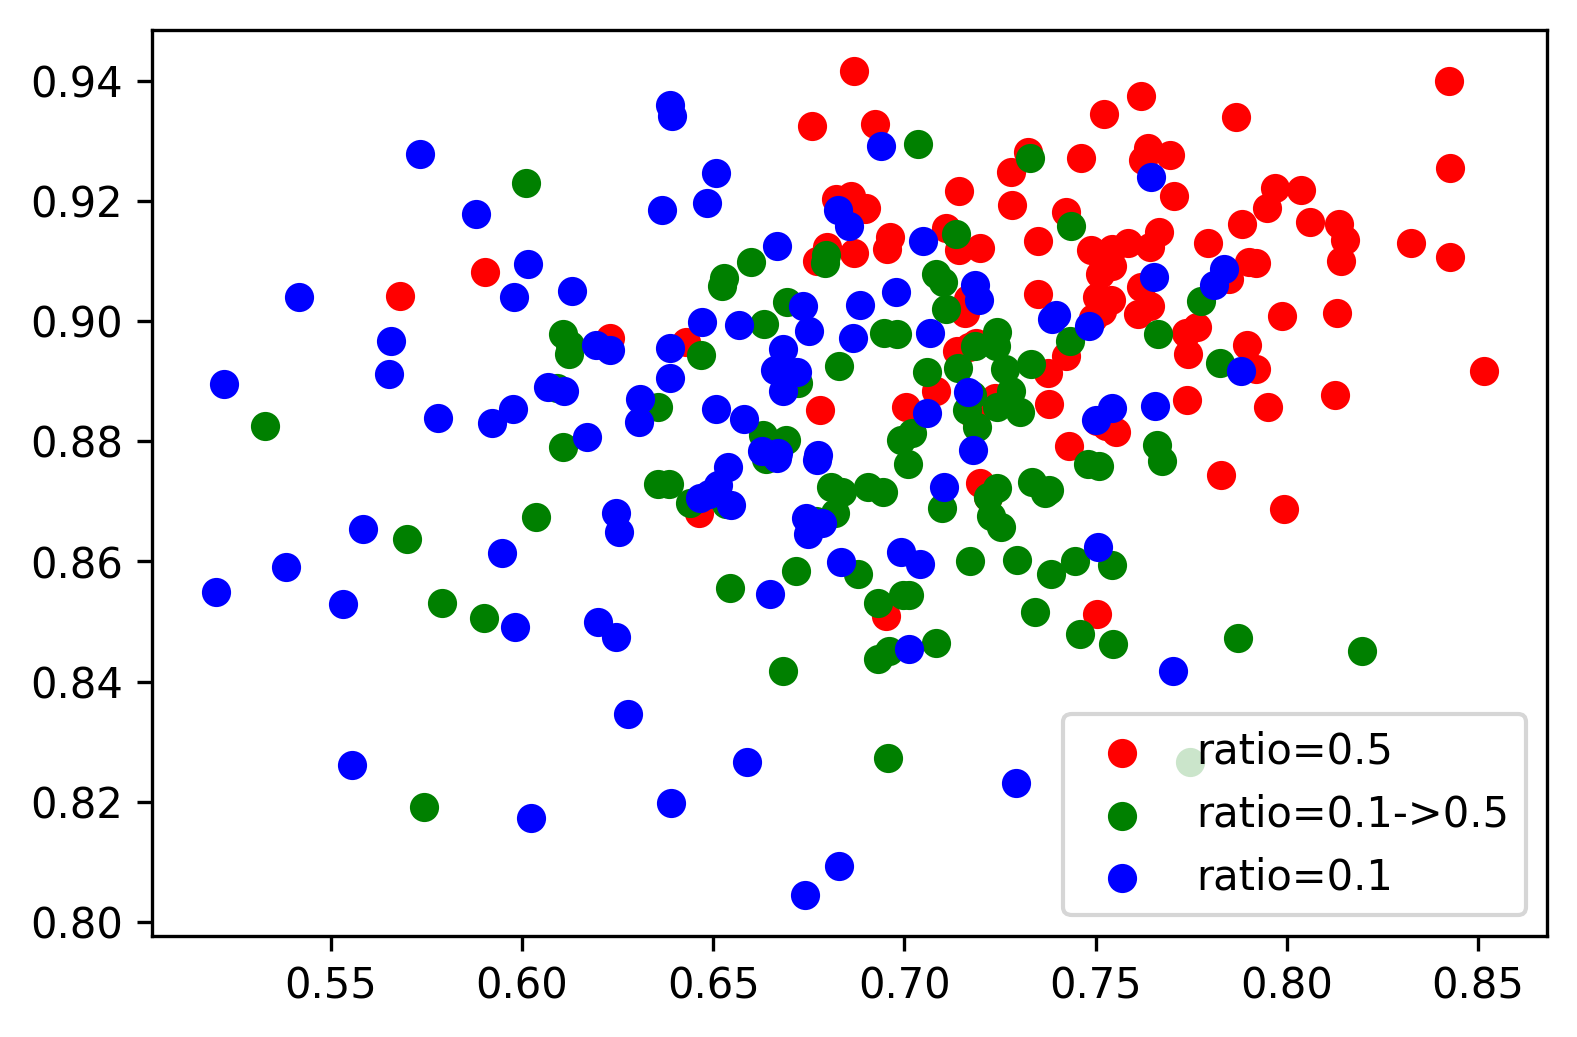

In [136]:
plt.scatter(preds_og[:, picked[0]], preds_og[:, picked[1]], c='r', label='ratio=0.5')
plt.scatter(preds_shuffle[:, picked[0]], preds_shuffle[:, picked[1]], c='g', label='ratio=0.1->0.5')
plt.scatter(preds_noshuffle[:, picked[0]], preds_noshuffle[:, picked[1]], c='b', label='ratio=0.1')
plt.legend()

In [137]:
og_within_sim = cosine_similarity(preds_og, preds_og)
shuffle_within_sim = cosine_similarity(preds_shuffle, preds_shuffle)
noshuffle_within_sim = cosine_similarity(preds_noshuffle, preds_noshuffle)

og_shuffle_sim = cosine_similarity(preds_og, preds_shuffle)
og_noshuffle_sim = cosine_similarity(preds_og, preds_noshuffle)

shuffle_before_after_sim = cosine_similarity(preds_shuffle, preds_noshuffle)

In [138]:
np.mean(og_shuffle_sim)

0.992372

In [139]:
np.mean(og_noshuffle_sim)

0.9929403

In [140]:
np.mean(shuffle_before_after_sim)

0.99189484